In [46]:
#numpy
import numpy as np
#importing pandas
import pandas as pd
#matplotlib
import matplotlib.pyplot as plt
#seaborn
import seaborn as sns
#Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
#pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
#train_test_split
from sklearn.model_selection import train_test_split
#result
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Loading the Dataset

In [29]:
df=pd.read_json('/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json',lines=True)
#showing the dataset
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


# Getting the Preliminary Information about the dataset

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


# Checking for null values in the dataset

In [31]:
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

In [32]:
mapping=dict(enumerate(df['category'].unique()))
label_mapping={value:key for  key,value in mapping.items()}

In [33]:
label_mapping

{'U.S. NEWS': 0,
 'COMEDY': 1,
 'PARENTING': 2,
 'WORLD NEWS': 3,
 'CULTURE & ARTS': 4,
 'TECH': 5,
 'SPORTS': 6,
 'ENTERTAINMENT': 7,
 'POLITICS': 8,
 'WEIRD NEWS': 9,
 'ENVIRONMENT': 10,
 'EDUCATION': 11,
 'CRIME': 12,
 'SCIENCE': 13,
 'WELLNESS': 14,
 'BUSINESS': 15,
 'STYLE & BEAUTY': 16,
 'FOOD & DRINK': 17,
 'MEDIA': 18,
 'QUEER VOICES': 19,
 'HOME & LIVING': 20,
 'WOMEN': 21,
 'BLACK VOICES': 22,
 'TRAVEL': 23,
 'MONEY': 24,
 'RELIGION': 25,
 'LATINO VOICES': 26,
 'IMPACT': 27,
 'WEDDINGS': 28,
 'COLLEGE': 29,
 'PARENTS': 30,
 'ARTS & CULTURE': 31,
 'STYLE': 32,
 'GREEN': 33,
 'TASTE': 34,
 'HEALTHY LIVING': 35,
 'THE WORLDPOST': 36,
 'GOOD NEWS': 37,
 'WORLDPOST': 38,
 'FIFTY': 39,
 'ARTS': 40,
 'DIVORCE': 41}

In [34]:
NUM_CLASSES=len(label_mapping)
print(NUM_CLASSES)

42


# Creating the Function called Preprocessing

In [36]:
def get_sequences(texts,tokenizer,train=True,max_seq_length=0):
    sequences=tokenizer.texts_to_sequences(texts)
    if train==True:
        max_seq_length=np.max(list(map(lambda x:len(x),sequences)))
    sequences=pad_sequences(sequences,maxlen=max_seq_length,padding='post')
    return sequences
    

In [42]:
def preprocess_inputs(df,label_mapping):
    df=df.copy()
    df=df.loc[:,['headline','category']]
    df['category']=df['category'].replace(label_mapping)
    #Sampple 1000 examples from each category
    category_sample=[]
    for category in df['category'].unique():
        category_slice=df.query("category==@category")
        category_sample.append(category_slice.sample(1000,random_state=1))
    df=pd.concat(category_sample,axis=0).sample(frac=1.0,random_state=1).reset_index(drop=True)
    #Split df into x and y
    y=df['category']
    x=df['headline']
    #train_test_split
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7)
    
    tokenizer=Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(x_train)
    
    x_train=get_sequences(x_train,tokenizer,train=True)
    x_test=get_sequences(x_test,tokenizer,train=False,max_seq_length=x_train.shape[1])
    return x_train,x_test,y_train,y_test


# #we can use environment variable with @ sign

In [43]:
x_train,x_test,y_train,y_test=preprocess_inputs(df,label_mapping)
x_train

array([[  93,  883,    4, ...,    0,    0,    0],
       [ 913,    1,  759, ...,    0,    0,    0],
       [ 155,  394,   18, ...,    0,    0,    0],
       ...,
       [  13,    2,    1, ...,    0,    0,    0],
       [ 756,  577, 2929, ...,    0,    0,    0],
       [ 818, 1187,    6, ...,    0,    0,    0]], dtype=int32)

In [44]:
x_test

array([[   1,  479,    3, ...,    0,    0,    0],
       [ 589,  148, 9295, ...,    0,    0,    0],
       [ 216,  765, 1115, ...,    0,    0,    0],
       ...,
       [  81,  831,  329, ...,    0,    0,    0],
       [8280, 5763,    8, ...,    0,    0,    0],
       [  19, 1743,    4, ...,    0,    0,    0]], dtype=int32)

# Modeling

In [55]:
inputs=tf.keras.Input(shape=(x_train.shape[1],))
embedding=tf.keras.layers.Embedding(
    input_dim=10000,
    output_dim=64)(inputs)
flatten=tf.keras.layers.Flatten()(embedding)
dense_1=-tf.keras.layers.Dense(128,activation='relu')(flatten)
dense_2=tf.keras.layers.Dense(128,activation='relu')(dense_1)
outputs=tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')(dense_2)
model=tf.keras.Model(inputs,outputs)
print(model.summary())
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 27)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 27, 64)            640000    
                                                                 
 flatten_5 (Flatten)         (None, 1728)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               221312    
                                                                 
 tf.math.negative_4 (TFOpLam  (None, 128)              0         
 bda)                                                            
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                             

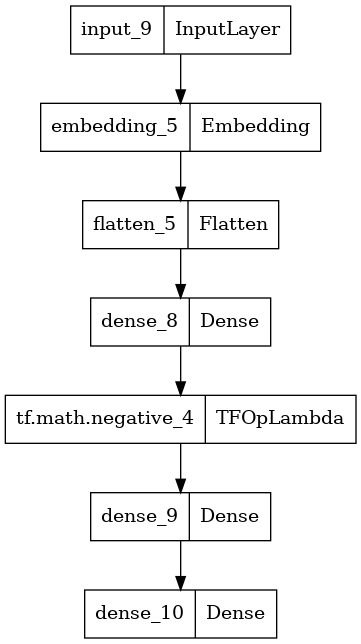

In [56]:
tf.keras.utils.plot_model(model)

# Training

In [57]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
history=model.fit(x_train,y_train,validation_split=0.2,epochs=100,
                 callbacks=[tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss',patience=3,restore_best_weights=True)])

Epoch 1/100
735/735 [==============================] - 9s 11ms/step - loss: 3.4802 - accuracy: 0.0746 - val_loss: 3.0377 - val_accuracy: 0.1776
Epoch 2/100
735/735 [==============================] - 8s 11ms/step - loss: 2.3687 - accuracy: 0.3407 - val_loss: 2.5966 - val_accuracy: 0.3197
Epoch 3/100
735/735 [==============================] - 8s 11ms/step - loss: 1.2436 - accuracy: 0.6439 - val_loss: 3.1004 - val_accuracy: 0.3145
Epoch 4/100
735/735 [==============================] - 8s 11ms/step - loss: 0.5055 - accuracy: 0.8631 - val_loss: 3.9286 - val_accuracy: 0.2981
Epoch 5/100
735/735 [==============================] - 8s 11ms/step - loss: 0.1897 - accuracy: 0.9540 - val_loss: 4.7179 - val_accuracy: 0.2957


# Results

In [58]:
model.evaluate(x_test,y_test)

394/394 [==============================] - 1s 3ms/step - loss: 2.5773 - accuracy: 0.3114


[2.5772836208343506, 0.31140387058258057]

394/394 [==============================] - 1s 2ms/step


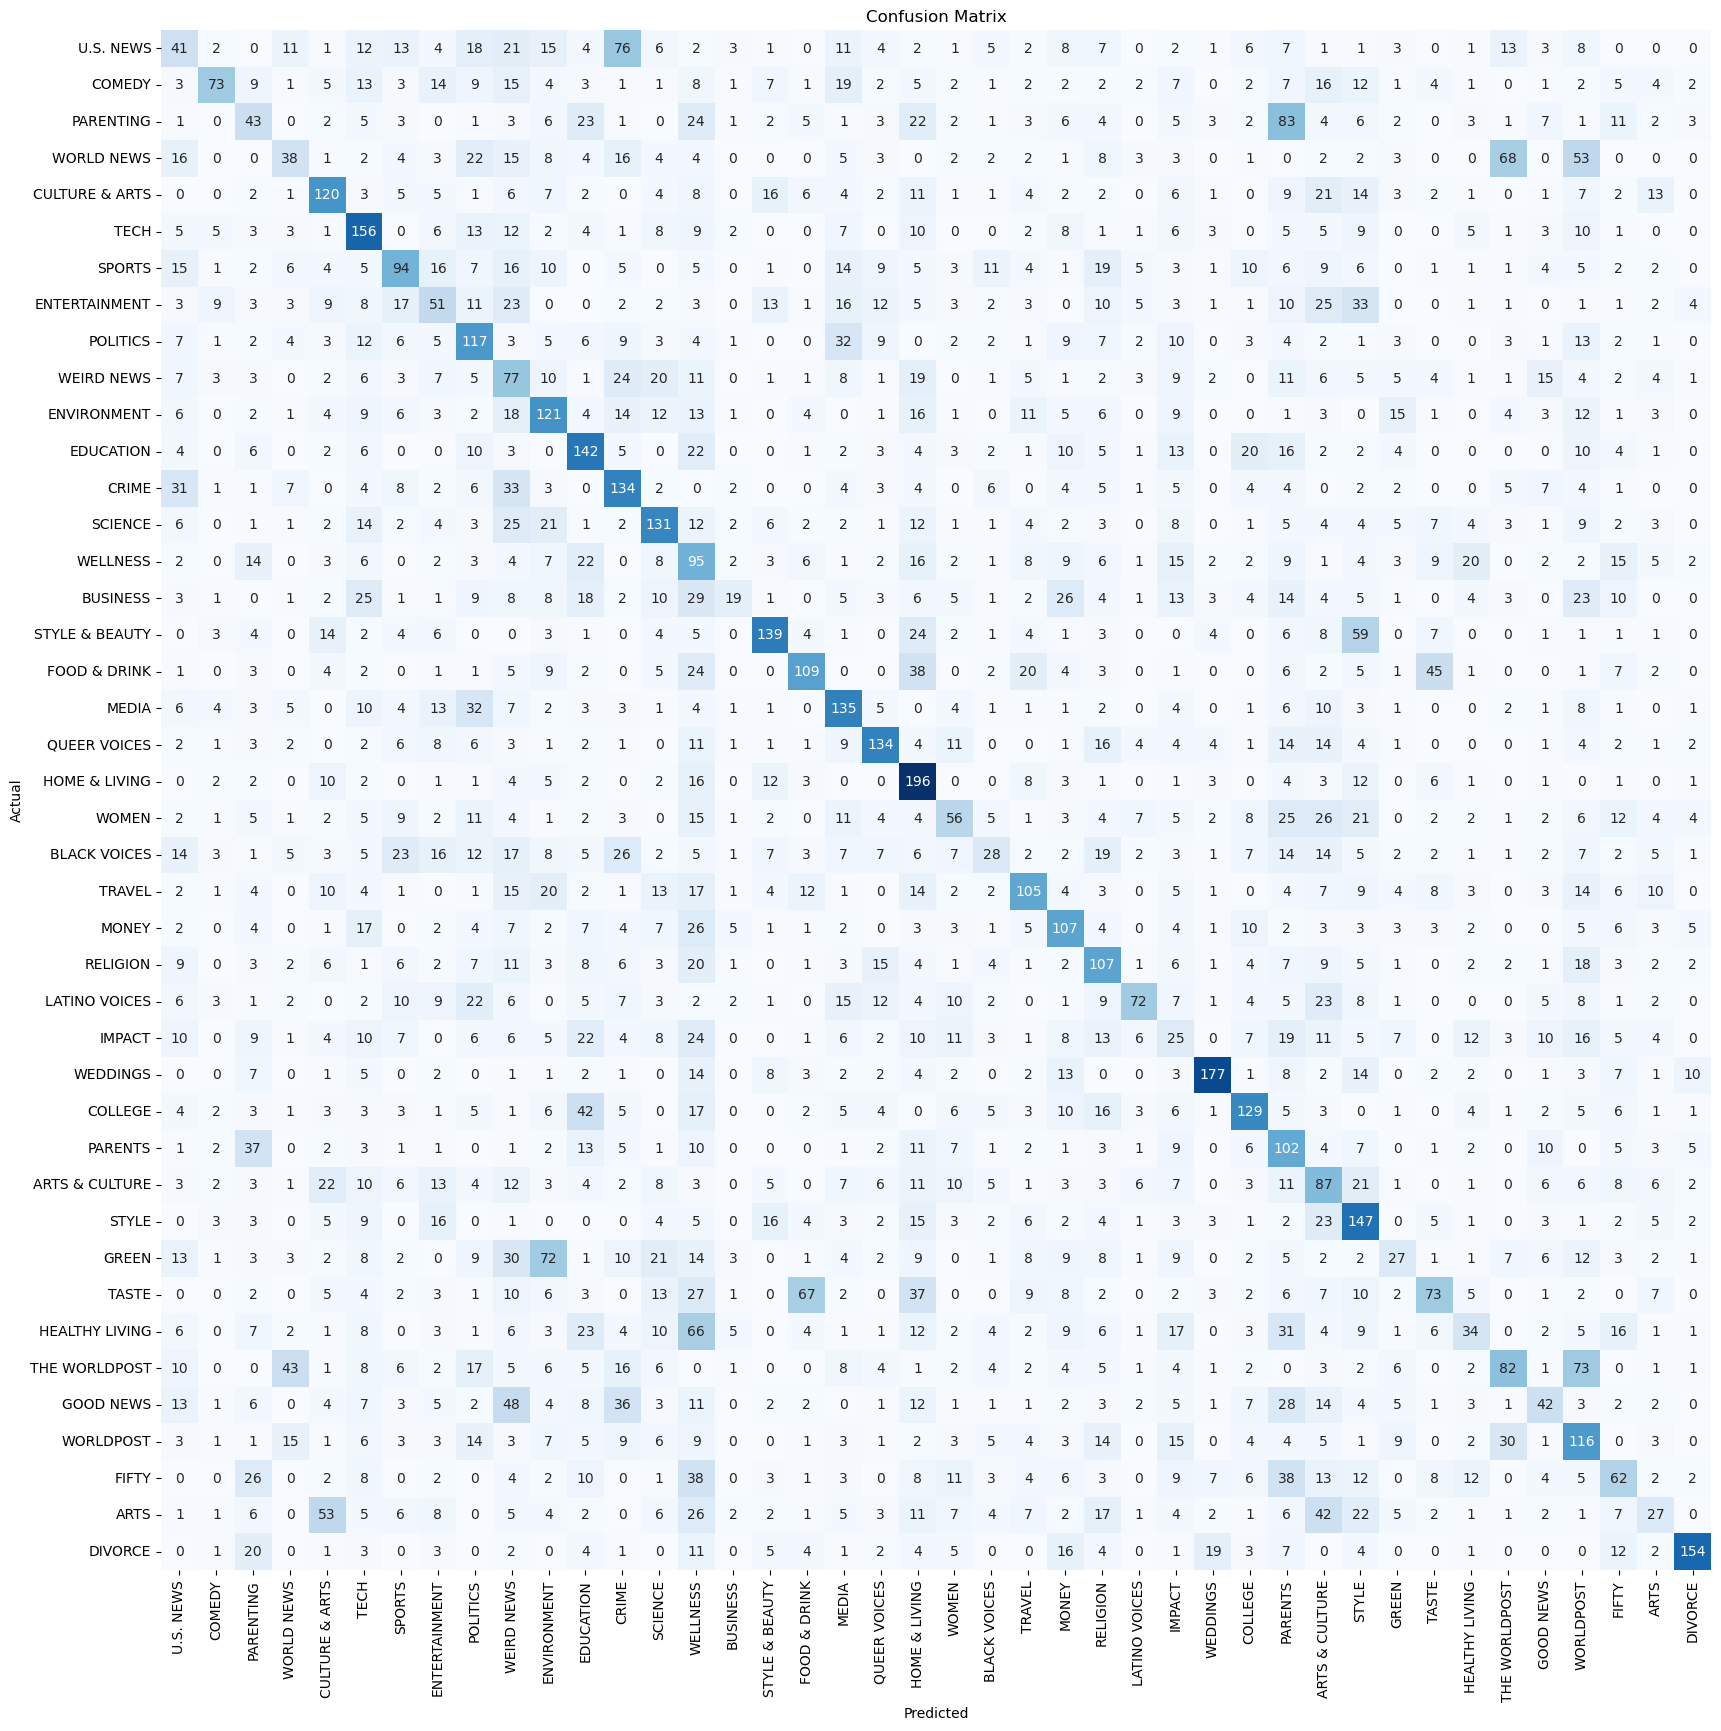

In [64]:
y_pred=np.argmax(model.predict(x_test),axis=1)
cm=confusion_matrix(y_test,y_pred)
clr=classification_report(y_test,y_pred,target_names=list(label_mapping.keys()))
plt.figure(figsize=(20,20))
sns.heatmap(cm,annot=True,vmin=0,fmt='g',cmap='Blues',cbar=False)
plt.xticks(ticks=np.arange(NUM_CLASSES)+0.5,labels=
          list(label_mapping.keys()),rotation=90)
plt.yticks(ticks=np.arange(NUM_CLASSES)+0.5,
          labels=list(label_mapping.keys()),rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()








In [63]:
print('Classification Report:\n-----------\n',clr)

Classification Report:
-----------
                 precision    recall  f1-score   support

     U.S. NEWS       0.16      0.13      0.14       316
        COMEDY       0.57      0.27      0.36       272
     PARENTING       0.17      0.15      0.16       295
    WORLD NEWS       0.24      0.13      0.17       295
CULTURE & ARTS       0.38      0.41      0.39       293
          TECH       0.36      0.51      0.42       307
        SPORTS       0.35      0.30      0.33       309
 ENTERTAINMENT       0.21      0.17      0.19       297
      POLITICS       0.30      0.40      0.34       295
    WEIRD NEWS       0.16      0.26      0.20       291
   ENVIRONMENT       0.30      0.39      0.34       312
     EDUCATION       0.34      0.47      0.39       304
         CRIME       0.31      0.45      0.37       295
       SCIENCE       0.39      0.41      0.40       317
      WELLNESS       0.14      0.30      0.19       314
      BUSINESS       0.32      0.07      0.11       275
STYLE & BEA

In [59]:
y_pred=np.argmax(model.predict(x_test),axis=1)

394/394 [==============================] - 1s 2ms/step


In [60]:
y_pred

array([36, 13,  5, ..., 13,  7, 33])

Loading the Dat